In [1]:
pip install tensorflow_recommenders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 1.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
# df = drive.mount('/content/drive/MyDrive/amazon.csv')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from typing import Dict, Text
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_recommenders as tfrs
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow.keras.layers import Embedding, Input, Dense
from tensorflow.keras.models import Model
from google.colab import files

import warnings; warnings.simplefilter('ignore')
%matplotlib inline

# Load Data

In [4]:
df = pd.read_csv('TrackMate Dataset.csv', on_bad_lines = 'skip')

In [5]:
df_new = df.copy()
df_new.tail(7)

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
1458,B07J9KXQCC,"Libra Room Heater for Home, Room Heaters Home ...","Home&Kitchen|Heating,Cooling&AirQuality|RoomHe...",₹949,"₹2,299",59%,3.6,550,"Libra room heater for home has cool, warm or h...","AE5FZ5B3EEES45Q26PNUBTJ5DRYA,AGL2B432J2VDHOSUW...","gitesh jaiswal,Divyansh,Dr Paras,Amazon Custom...","R363CESXF8MX1J,RPFBIUJQY7U8J,R1RANSDWMZLOFX,R2...",Product functioning ok but price is quite high...,For the product like room heater package shoul...,https://m.media-amazon.com/images/I/51GEjZAmNR...,https://www.amazon.in/LIBRA-Portable-Heater-Ad...
1459,B0B3JSWG81,NGI Store 2 Pieces Pet Hair Removers for Your ...,"Home&Kitchen|Kitchen&HomeAppliances|Vacuum,Cle...",₹199,₹999,80%,3.1,2,"Versatile, Protects Your Clothes: MoveCatcher ...",AFPKVN5KLHB4MHSYDS25Q5MIWWKQ,Kunal Sen,R18OKMWGX8SA0L,Useless,Does not work as advertised at all. The pieces...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Hair-Removers-Laundry-Re...
1460,B08L7J3T31,Noir Aqua - 5pcs PP Spun Filter + 1 Spanner | ...,Home&Kitchen|Kitchen&HomeAppliances|WaterPurif...,₹379,₹919,59%,4,"1,090",SUPREME QUALITY 90 GRAM 3 LAYER THIK PP SPUN F...,"AHITFY6AHALOFOHOZEOC6XBP4FEA,AFRABBODZJZQB6Z4U...","Prabha ds,Raghuram bk,Real Deal,Amazon Custome...","R3G3XFHPBFF0E8,R3C0BZCD32EIGW,R2EBVBCN9QPD9R,R...","Received the product without spanner,Excellent...","I received product without spanner,Excellent p...",https://m.media-amazon.com/images/I/41fDdRtjfx...,https://www.amazon.in/Noir-Aqua-Spanner-Purifi...
1461,B01M6453MB,Prestige Delight PRWO Electric Rice Cooker (1 ...,Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,"₹2,280","₹3,045",25%,4.1,"4,118","230 Volts, 400 watts, 1 Year","AFG5FM3NEMOL6BNFRV2NK5FNJCHQ,AGEINTRN6Z563RMLH...","Manu Bhai,Naveenpittu,Evatira Sangma,JAGANNADH...","R3DDL2UPKQ2CK9,R2SYYU1OATVIU5,R1VM993161IYRW,R...","ok,everything was good couldn't return bcoz I ...","ok,got everything as mentioned but the measuri...",https://m.media-amazon.com/images/I/41gzDxk4+k...,https://www.amazon.in/Prestige-Delight-PRWO-1-...
1462,B009P2LIL4,Bajaj Majesty RX10 2000 Watts Heat Convector R...,"Home&Kitchen|Heating,Cooling&AirQuality|RoomHe...","₹2,219","₹3,080",28%,3.6,468,International design and styling|Two heat sett...,"AGVPWCMAHYQWJOQKMUJN4DW3KM5Q,AF4Q3E66MY4SR7YQZ...","Nehal Desai,Danish Parwez,Amazon Customer,Amaz...","R1TLRJVW4STY5I,R2O455KRN493R1,R3Q5MVGBRIAS2G,R...","very good,Work but front melt after 2 month,Go...","plastic but cool body ,u have to find sturdy s...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Bajaj-RX-10-2000-Watt-Co...
1463,B00J5DYCCA,Havells Ventil Air DSP 230mm Exhaust Fan (Pist...,"Home&Kitchen|Heating,Cooling&AirQuality|Fans|E...","₹1,399","₹1,890",26%,4,"8,031",Fan sweep area: 230 MM ; Noise level: (40 - 45...,"AF2JQCLSCY3QJATWUNNHUSVUPNQQ,AFDMLUXC5LS5RXDJS...","Shubham Dubey,E.GURUBARAN,Mayank S.,eusuf khan...","R39Q2Y79MM9SWK,R3079BG1NIH6MB,R29A31ZELTZNJM,R...","Fan Speed is slow,Good quality,Good product,go...",I have installed this in my kitchen working fi...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Havells-Ventilair-230mm-...
1464,B01486F4G6,Borosil Jumbo 1000-Watt Grill Sandwich Maker (...,Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,"₹2,863","₹3,690",22%,4.3,"6,987","Brand-Borosil, Specification â€“ 23V ~ 5Hz;1 W...","AFGW5PT3R6ZAVQR4Y5MWVAKBZAYA,AG7QNJ2SCS5VS5VYY...","Rajib,Ajay B,Vikas Kahol,PARDEEP,Anindya Prama...","R20RBRZ0WEUJT9,ROKIFK9R2ISSE,R30EEG2FNJSN5I,R2...","Works perfect,Ok good product,Nice Product. Re...",It does it job perfectly..only issue is temp c...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Borosil-Jumbo-1000-Watt-...


In [6]:
jumlah_baris = len(df_new)
print(f"Jumlah baris dalam dataset: {jumlah_baris}")

Jumlah baris dalam dataset: 1465


In [7]:
# Data produk baru yang ingin ditambahkan
data_produk_baru_1 = [
    {
    'product_id': 'B112X5ADO8',
    'product_name': 'Greenbean Coffee',
    'category': 'Grocery and Gourmet Food',
    'discounted_price': '₹80,000',
    'actual_price': '₹80,000',
    'discount_percentage': '0%',
    'rating': 4.9,
    'rating_count': '7',
    'about_product': 'Cerry kopi yang sudah mengalami proses pasca panen dan siap panggang',
    'user_id': "AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PTWOOIKUOIDHA,AFRMNW6TDHDZBP2UHF2K3MEAEYUA,AHICHCW6EC3BNV2IDAEAJPBG4HZQ,AGWFKE7RNP6EVC4JFLFSL76EEVVQ,AGEOQQHGNELZNEUKJAJUA7NTPBLA,AFS3QBSOMCE2FAZFUYZ3NBFQDLMQ,AGJYG6ZWCWD74WNE6Y37XZ2VUSMA",
    'user_name': "Birendra ku Dash,Aditya Gupta,Abdulla A N,Deepak,Gowtham,Rakesh,Pawan Kumar,Prabhat Raj Pathak",
    'review_id': "A1B2C3D4E5F6G7H8, I9J1K2L3M4N5O6, P7Q8R9S1T2U3V4, W5X6Y7Z8A9B1C2, D3E4F5G6H7I8J9, K1L2M3N4O5P6Q7, R8S9T1U2V3W4X5, Y6Z7A8B9C1D2E3",
    'review_title': "Rasa autentik dan khas, bahan-bahan segar terasa, penyajian cantik dan instagramable, menu ramah vegetarian, tempat yang bersih dan nyaman, suasana tenang, pilihan sehat dan bergizi, layanan ramah.",
    'review_content': 'Revolutionary, high-quality, elegant design, affordable, user-friendly, functional, fast delivery, highly recommended for any product!',
    'img_link': 'https://drive.google.com/open?id=1mCbKdwvUu9lZV-uC18Ak9_oAACyy18YH',
    'product_link': 'https://www.instagram.com/agroniaga_idn/'
},
    {
    'product_id': 'B613M6MSA8',
    'product_name': 'MORINGA TEA',
    'category': 'Grocery and Gourmet Food',
    'discounted_price': '₹40,000',
    'actual_price': '₹40,000',
    'discount_percentage': '0%',
    'rating': 4.9,
    'rating_count': '7',
    'about_product': "Produk berbahan dasar daun kelor yang bentuk kemasan teabag tinggal seduh.",
    'user_id': "AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PTWOOIKUOIDHA,AFRMNW6TDHDZBP2UHF2K3MEAEYUA,AHICHCW6EC3BNV2IDAEAJPBG4HZQ,AGWFKE7RNP6EVC4JFLFSL76EEVVQ,AGEOQQHGNELZNEUKJAJUA7NTPBLA,AFS3QBSOMCE2FAZFUYZ3NBFQDLMQ,AGJYG6ZWCWD74WNE6Y37XZ2VUSMA",
    'user_name': "Birendra ku Dash,Aditya Gupta,Abdulla A N,Deepak,Gowtham,Rakesh,Pawan Kumar,Prabhat Raj Pathak",
    'review_id': "AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PTWOOIKUOIDHA,AFRMNW6TDHDZBP2UHF2K3MEAEYUA,AHICHCW6EC3BNV2IDAEAJPBG4HZQ,AGWFKE7RNP6EVC4JFLFSL76EEVVQ,AGEOQQHGNELZNEUKJAJUA7NTPBLA,AFS3QBSOMCE2FAZFUYZ3NBFQDLMQ,AGJYG6ZWCWD74WNE6Y37XZ2VUSMA",
    'review_title': "Makanan sehat dan organik, pilihan vegan yang baik, desain interior yang Instagramable, suasana yang tenang dan ramah lingkungan, menu salad yang kreatif, harga terjangkau untuk makanan sehat, pelayanan yang ramah dan informatif.",
    'review_content': 'Revolutionary, high-quality, elegant design, affordable, user-friendly, functional, fast delivery, highly recommended for any product!',
    'img_link': 'https://drive.google.com/open?id=18osvUd5nE_Uu21d6c3aqi7ccPbT6dxOQ',
    'product_link': 'https://www.tokopedia.com/archive-newedenmoringa-1645404339/moringa-tea-new-eden-20gr?extParam=src%3Dshop%26whid%3D9669096'
},
    {
         'product_id': 'B404F7FMA1',
    'product_name': 'TEMPEKITA TEMPE SEGAR',
    'category': 'Grocery and Gourmet Food',
    'discounted_price': '₹17,000',
    'actual_price': '₹17,000',
    'discount_percentage': '0%',
    'rating': 4.9,
    'rating_count': '7',
    'about_product': "Tempe segar adalah produk yang berasal dari kacang kedelai yang difermentasi menggunakan ragi tempe.",
    'user_id': "AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PTWOOIKUOIDHA,AFRMNW6TDHDZBP2UHF2K3MEAEYUA,AHICHCW6EC3BNV2IDAEAJPBG4HZQ,AGWFKE7RNP6EVC4JFLFSL76EEVVQ,AGEOQQHGNELZNEUKJAJUA7NTPBLA,AFS3QBSOMCE2FAZFUYZ3NBFQDLMQ,AGJYG6ZWCWD74WNE6Y37XZ2VUSMA",
    'user_name': "Birendra ku Dash,Aditya Gupta,Abdulla A N,Deepak,Gowtham,Rakesh,Pawan Kumar,Prabhat Raj Pathak",
    'review_id': "M8N9O1P2Q3R4S5T6U7V8W9, X1Y2Z3A4B5C6D7E8F9G1H2I3J4K5, L6M7N8O9P1Q2R3S4T5U6V7W8X9, Y1Z2A3B4C5D6E7F8G9H1I2J3K4L5, M6N7O8P9Q1R2S3T4U5V6W7X8Y9, Z1A2B3C4D5E6F7G8H9I1J2K3L4, M5N6O7P8Q9R1S2T3U4V5W6, X7Y8Z9A1B2C3D4E5F6G7",
    'review_title': "Makanan sehat dan organik, pilihan vegan yang baik, desain interior yang Instagramable, suasana yang tenang dan ramah lingkungan, menu salad yang kreatif, harga terjangkau untuk makanan sehat, pelayanan yang ramah dan informatif.",
    'review_content': 'Revolutionary, high-quality, elegant design, affordable, user-friendly, functional, fast delivery, highly recommended for any product!',
    'img_link': 'https://drive.google.com/open?id=1fv6EFhTNGeAuZgMapiOODILB3um7LgOX',
    'product_link': 'https://shopee.co.id/-Tempekita.id-Tempe-Segar-i.419555041.8543489708?xptdk=8ec5c78a-ef7b-4600-b5ab-8652b22055eb'
    },
    {
        'product_id': 'B772O6JWR8',
    'product_name': 'ZAKET',
    'category': 'Home&Kitchen',
    'discounted_price': '₹28,000',
    'actual_price': '₹28,000',
    'discount_percentage': '0%',
    'rating': 4.9,
    'rating_count': '7',
    'about_product': "Terbuat dari limbah sawit",
    'user_id': "AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PTWOOIKUOIDHA,AFRMNW6TDHDZBP2UHF2K3MEAEYUA,AHICHCW6EC3BNV2IDAEAJPBG4HZQ,AGWFKE7RNP6EVC4JFLFSL76EEVVQ,AGEOQQHGNELZNEUKJAJUA7NTPBLA,AFS3QBSOMCE2FAZFUYZ3NBFQDLMQ,AGJYG6ZWCWD74WNE6Y37XZ2VUSMA",
    'user_name': "Birendra ku Dash,Aditya Gupta,Abdulla A N,Deepak,Gowtham,Rakesh,Pawan Kumar,Prabhat Raj Pathak",
    'review_id': "O8P9Q1R2S3T4U5V6W7X8Y9, Z1A2B3C4D5E6F7G8H9I1J2K3, L4M5N6O7P8Q9R1S2T3U4V5W6, X7Y8Z9A1B2C3D4E5F6G7H8, I9J1K2L3M4N5O6P7Q8R9S1T2, U3V4W5X6Y7Z8A9B1C2D3E4F5, G6H7I8J9K1L2M3N4O5P6, Q7R8S9T1U2V3W4X5Y6Z7",
    'review_title': "Arang dari limbah ini adalah solusi ramah lingkungan yang brilian, Mengubah limbah menjadi sumber energi yang berguna, ini membantu mengurangi jejak karbon, Proses daur ulang limbah menjadi arang sangat inovatif dan membantu menjaga lingkungan, Saya sangat mendukung produk-produk yang memprioritaskan keberlanjutan, arang dari limbah ini adalah langkah positif menuju masa depan yang lebih hijau dan berkelanjutan.",
    'review_content': 'Revolutionary, high-quality, elegant design, affordable, user-friendly, functional, fast delivery, highly recommended for any product!',
    'img_link': 'https://drive.google.com/open?id=1JTMePUNF4XMWe8IW5VW5et513nESlgWB',
    'product_link': 'https://drive.google.com/open?id=1JTMePUNF4XMWe8IW5VW5et513nESlgWB'
    },
    {
         'product_id': 'B103G6MHZ9',
    'product_name': 'Mutiara Beras Glukomanan Porang',
    'category': 'Grocery and Gourmet Food',
    'discounted_price': '₹135,000',
    'actual_price': '₹135,000',
    'discount_percentage': '0%',
    'rating': 4.9,
    'rating_count': '7',
    'about_product': "Nasi tinggi serat rendah karbohidrat rendah kalori dan rendah gula",
    'user_id': "AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PTWOOIKUOIDHA,AFRMNW6TDHDZBP2UHF2K3MEAEYUA,AHICHCW6EC3BNV2IDAEAJPBG4HZQ,AGWFKE7RNP6EVC4JFLFSL76EEVVQ,AGEOQQHGNELZNEUKJAJUA7NTPBLA,AFS3QBSOMCE2FAZFUYZ3NBFQDLMQ,AGJYG6ZWCWD74WNE6Y37XZ2VUSMA",
    'user_name': "Birendra ku Dash,Aditya Gupta,Abdulla A N,Deepak,Gowtham,Rakesh,Pawan Kumar,Prabhat Raj Pathak",
    'review_id': "A8B9C1D2E3F4G5H6I7J8, K9L1M2N3O4P5Q6R7S8T9U1V2W3, X4Y5Z6A7B8C9D1E2F3G4H5I6J7, K8L9M1N2O3P4Q5R6S7T8U9V1W2, X3Y4Z5A6B7C8D9E1F2G3H4I5, J6K7L8M9N1O2P3Q4R5S6T7, U8V9W1X2Y3Z4A5B6C7D8, E9F1G2H3I4J5K6L7M8N9O1P2",
    'review_title': "Makanan sehat dan organik, pilihan vegan yang baik, desain interior yang Instagramable, suasana yang tenang dan ramah lingkungan, menu salad yang kreatif, harga terjangkau untuk makanan sehat, pelayanan yang ramah dan informatif.",
    'review_content': 'Revolutionary, high-quality, elegant design, affordable, user-friendly, functional, fast delivery, highly recommended for any product!',
    'img_link': 'https://drive.google.com/open?id=1xUJLdhbxytbRK9u1IdTXN9h3jETHAJVi',
    'product_link': 'https://dapurporang.com/'
    },
      {   'product_id': 'B307H9TVZ8',
    'product_name': 'Nasi Jagung Instan Loyangku',
    'category': 'Grocery and Gourmet Food',
    'discounted_price': '₹15,000',
    'actual_price': '₹15,000',
    'discount_percentage': '0%',
    'rating': 4.9,
    'rating_count': '7',
    'about_product': "Nasi Jagung Instan Loyangku terbuat dari jagung pilihan dari petani jagung Banjarnegara yang diolah secara tradisioanal oleh masyarakat Desa Pucungbedug. Yuk hidup sehat bersama Nasi Jagung Instan Loyangku.",
    'user_id': "AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PTWOOIKUOIDHA,AFRMNW6TDHDZBP2UHF2K3MEAEYUA,AHICHCW6EC3BNV2IDAEAJPBG4HZQ,AGWFKE7RNP6EVC4JFLFSL76EEVVQ,AGEOQQHGNELZNEUKJAJUA7NTPBLA,AFS3QBSOMCE2FAZFUYZ3NBFQDLMQ,AGJYG6ZWCWD74WNE6Y37XZ2VUSMA",
    'user_name': "Birendra ku Dash,Aditya Gupta,Abdulla A N,Deepak,Gowtham,Rakesh,Pawan Kumar,Prabhat Raj Pathak",
    'review_id': "Q3R4S5T6U7V8W9X1Y2Z3A4, B5C6D7E8F9G1H2I3J4K5L6M7N8O9, P1Q2R3S4T5U6V7W8X9Y1Z2A3B4C5D6E7, F8G9H1I2J3K4L5M6N7O8P9Q1R2S3T4, U5V6W7X8Y9Z1A2B3C4D5E6F7G8H9, I1J2K3L4M5N6O7P8Q9R1S2T3U4V5, W6X7Y8Z9A1B2C3D4E5F6G7H8, I9J1K2L3M4N5O6P7Q8R9S1T2",
    'review_title': "Makanan sehat dan organik, pilihan vegan yang baik, desain interior yang Instagramable, suasana yang tenang dan ramah lingkungan, menu salad yang kreatif, harga terjangkau untuk makanan sehat, pelayanan yang ramah dan informatif.",
    'review_content': 'Revolutionary, high-quality, elegant design, affordable, user-friendly, functional, fast delivery, highly recommended for any product!',
    'img_link': 'https://drive.google.com/open?id=1auE4DYUhpOjOSn-P_Fk7akmAHzNoCj7e',
    'product_link': 'https://gubug-eva.business.site/'
    },
     {    'product_id': 'B397P6QHS8',
    'product_name': 'Sambal Baby Cumi',
    'category': 'Grocery and Gourmet Food',
    'discounted_price': '₹40,000',
    'actual_price': '₹40,000',
    'discount_percentage': '0%',
    'rating': 4.9,
    'rating_count': '7',
    'about_product': 'Sambal yang terbuat dari baby cumi asin yang berasal dari daerah desa Gerokgak kec. Gerokgak Kab. Buleleng beserta aneka cabai dan rempah-rempah bumbu segar tanpa pengawet yang diolah dengan cara dimasak sehingga memiliki rasa yang pedas, gurih dan nikmat. Cocok jika dimakan bersama nasi panas.',
    'user_id': "AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PTWOOIKUOIDHA,AFRMNW6TDHDZBP2UHF2K3MEAEYUA,AHICHCW6EC3BNV2IDAEAJPBG4HZQ,AGWFKE7RNP6EVC4JFLFSL76EEVVQ,AGEOQQHGNELZNEUKJAJUA7NTPBLA,AFS3QBSOMCE2FAZFUYZ3NBFQDLMQ,AGJYG6ZWCWD74WNE6Y37XZ2VUSMA",
    'user_name': "Birendra ku Dash,Aditya Gupta,Abdulla A N,Deepak,Gowtham,Rakesh,Pawan Kumar,Prabhat Raj Pathak",
    'review_id': "U3V4W5X6Y7Z8A9B1C2D3E4F5, G6H7I8J9K1L2M3N4O5P6Q7R8S9, T1U2V3W4X5Y6Z7A8B9C1D2E3F4G5, H6I7J8K9L1M2N3O4P5Q6R7S8T9U1, V2W3X4Y5Z6A7B8C9D1E2F3G4H5, I6J7K8L9M1N2O3P4,D3E4F5G6H7I8J9, K1L2M3N4O5P6Q7",
    'review_title': "Makanan sehat dan organik, pilihan vegan yang baik, desain interior yang Instagramable, suasana yang tenang dan ramah lingkungan, menu salad yang kreatif, harga terjangkau untuk makanan sehat, pelayanan yang ramah dan informatif.",
    'review_content': 'Revolutionary, high-quality, elegant design, affordable, user-friendly, functional, fast delivery, highly recommended for any product!',
    'img_link': 'https://www.instagram.com/sambal_mamo/',
    'product_link': 'https://shopee.co.id/sambal_mamo-i.997481767.21685181932?sp_atk=3e60a7ec-5e55-431a-9527-c1ee7d2dca32&xptdk=3e60a7ec-5e55-431a-9527-c1ee7d2dca32'
    }
    ]


In [8]:
df_new = df_new.append(data_produk_baru_1, ignore_index=True)
df_new.to_csv('TrackMate Dataset.csv', index=False)

In [9]:
jumlah_baris = len(df_new)
print(f"Jumlah baris dalam dataset: {jumlah_baris}")

Jumlah baris dalam dataset: 1472


In [10]:
df_new.tail(7)

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
1465,B112X5ADO8,Greenbean Coffee,Grocery and Gourmet Food,"₹80,000","₹80,000",0%,4.9,7,Cerry kopi yang sudah mengalami proses pasca p...,"AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PT...","Birendra ku Dash,Aditya Gupta,Abdulla A N,Deep...","A1B2C3D4E5F6G7H8, I9J1K2L3M4N5O6, P7Q8R9S1T2U3...","Rasa autentik dan khas, bahan-bahan segar tera...","Revolutionary, high-quality, elegant design, a...",https://drive.google.com/open?id=1mCbKdwvUu9lZ...,https://www.instagram.com/agroniaga_idn/
1466,B613M6MSA8,MORINGA TEA,Grocery and Gourmet Food,"₹40,000","₹40,000",0%,4.9,7,Produk berbahan dasar daun kelor yang bentuk k...,"AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PT...","Birendra ku Dash,Aditya Gupta,Abdulla A N,Deep...","AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PT...","Makanan sehat dan organik, pilihan vegan yang ...","Revolutionary, high-quality, elegant design, a...",https://drive.google.com/open?id=18osvUd5nE_Uu...,https://www.tokopedia.com/archive-newedenmorin...
1467,B404F7FMA1,TEMPEKITA TEMPE SEGAR,Grocery and Gourmet Food,"₹17,000","₹17,000",0%,4.9,7,Tempe segar adalah produk yang berasal dari ka...,"AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PT...","Birendra ku Dash,Aditya Gupta,Abdulla A N,Deep...","M8N9O1P2Q3R4S5T6U7V8W9, X1Y2Z3A4B5C6D7E8F9G1H2...","Makanan sehat dan organik, pilihan vegan yang ...","Revolutionary, high-quality, elegant design, a...",https://drive.google.com/open?id=1fv6EFhTNGeAu...,https://shopee.co.id/-Tempekita.id-Tempe-Segar...
1468,B772O6JWR8,ZAKET,Home&Kitchen,"₹28,000","₹28,000",0%,4.9,7,Terbuat dari limbah sawit,"AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PT...","Birendra ku Dash,Aditya Gupta,Abdulla A N,Deep...","O8P9Q1R2S3T4U5V6W7X8Y9, Z1A2B3C4D5E6F7G8H9I1J2...",Arang dari limbah ini adalah solusi ramah ling...,"Revolutionary, high-quality, elegant design, a...",https://drive.google.com/open?id=1JTMePUNF4XMW...,https://drive.google.com/open?id=1JTMePUNF4XMW...
1469,B103G6MHZ9,Mutiara Beras Glukomanan Porang,Grocery and Gourmet Food,"₹135,000","₹135,000",0%,4.9,7,Nasi tinggi serat rendah karbohidrat rendah ka...,"AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PT...","Birendra ku Dash,Aditya Gupta,Abdulla A N,Deep...","A8B9C1D2E3F4G5H6I7J8, K9L1M2N3O4P5Q6R7S8T9U1V2...","Makanan sehat dan organik, pilihan vegan yang ...","Revolutionary, high-quality, elegant design, a...",https://drive.google.com/open?id=1xUJLdhbxytbR...,https://dapurporang.com/
1470,B307H9TVZ8,Nasi Jagung Instan Loyangku,Grocery and Gourmet Food,"₹15,000","₹15,000",0%,4.9,7,Nasi Jagung Instan Loyangku terbuat dari jagun...,"AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PT...","Birendra ku Dash,Aditya Gupta,Abdulla A N,Deep...","Q3R4S5T6U7V8W9X1Y2Z3A4, B5C6D7E8F9G1H2I3J4K5L6...","Makanan sehat dan organik, pilihan vegan yang ...","Revolutionary, high-quality, elegant design, a...",https://drive.google.com/open?id=1auE4DYUhpOjO...,https://gubug-eva.business.site/
1471,B397P6QHS8,Sambal Baby Cumi,Grocery and Gourmet Food,"₹40,000","₹40,000",0%,4.9,7,Sambal yang terbuat dari baby cumi asin yang b...,"AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PT...","Birendra ku Dash,Aditya Gupta,Abdulla A N,Deep...","U3V4W5X6Y7Z8A9B1C2D3E4F5, G6H7I8J9K1L2M3N4O5P6...","Makanan sehat dan organik, pilihan vegan yang ...","Revolutionary, high-quality, elegant design, a...",https://www.instagram.com/sambal_mamo/,https://shopee.co.id/sambal_mamo-i.997481767.2...


# Data Cleaning

In [11]:
# check the number of rows and columns
df_new.shape

(1472, 16)

## Checking Missing Value

In [12]:
df_new.isna().sum()

product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           2
about_product          0
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
img_link               0
product_link           0
dtype: int64

In [13]:
df_new.dropna(inplace=True)
df_new.isna().sum()

product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           0
about_product          0
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
img_link               0
product_link           0
dtype: int64

In [14]:
df_new.shape

(1470, 16)

## Checking Duplicates

In [15]:
# Check for duplicates
def check_duplicates(dataframe):
    return dataframe.duplicated().sum()

print(check_duplicates(df_new))

0


## Changing Data Types

In [16]:
# Check data types
def check_data_types(dataframe):
    return dataframe.dtypes

print(check_data_types(df_new))

product_id             object
product_name           object
category               object
discounted_price       object
actual_price           object
discount_percentage    object
rating                 object
rating_count           object
about_product          object
user_id                object
user_name              object
review_id              object
review_title           object
review_content         object
img_link               object
product_link           object
dtype: object


In [17]:
# Split `category` column
cat_split = df_new['category'].str.split('|', expand=True)
cat_split.isnull().sum()

0       0
1       7
2      15
3     172
4     950
5    1385
6    1457
dtype: int64

In [18]:
# Rename column
cat_split = cat_split.rename(columns={0:'Main category', 1:'Sub category'})

In [19]:
# Add new cols to data frame and drop the old ones
df_new['category'] = cat_split['Main category']

In [20]:
df_new.tail(7)

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
1465,B112X5ADO8,Greenbean Coffee,Grocery and Gourmet Food,"₹80,000","₹80,000",0%,4.9,7,Cerry kopi yang sudah mengalami proses pasca p...,"AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PT...","Birendra ku Dash,Aditya Gupta,Abdulla A N,Deep...","A1B2C3D4E5F6G7H8, I9J1K2L3M4N5O6, P7Q8R9S1T2U3...","Rasa autentik dan khas, bahan-bahan segar tera...","Revolutionary, high-quality, elegant design, a...",https://drive.google.com/open?id=1mCbKdwvUu9lZ...,https://www.instagram.com/agroniaga_idn/
1466,B613M6MSA8,MORINGA TEA,Grocery and Gourmet Food,"₹40,000","₹40,000",0%,4.9,7,Produk berbahan dasar daun kelor yang bentuk k...,"AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PT...","Birendra ku Dash,Aditya Gupta,Abdulla A N,Deep...","AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PT...","Makanan sehat dan organik, pilihan vegan yang ...","Revolutionary, high-quality, elegant design, a...",https://drive.google.com/open?id=18osvUd5nE_Uu...,https://www.tokopedia.com/archive-newedenmorin...
1467,B404F7FMA1,TEMPEKITA TEMPE SEGAR,Grocery and Gourmet Food,"₹17,000","₹17,000",0%,4.9,7,Tempe segar adalah produk yang berasal dari ka...,"AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PT...","Birendra ku Dash,Aditya Gupta,Abdulla A N,Deep...","M8N9O1P2Q3R4S5T6U7V8W9, X1Y2Z3A4B5C6D7E8F9G1H2...","Makanan sehat dan organik, pilihan vegan yang ...","Revolutionary, high-quality, elegant design, a...",https://drive.google.com/open?id=1fv6EFhTNGeAu...,https://shopee.co.id/-Tempekita.id-Tempe-Segar...
1468,B772O6JWR8,ZAKET,Home&Kitchen,"₹28,000","₹28,000",0%,4.9,7,Terbuat dari limbah sawit,"AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PT...","Birendra ku Dash,Aditya Gupta,Abdulla A N,Deep...","O8P9Q1R2S3T4U5V6W7X8Y9, Z1A2B3C4D5E6F7G8H9I1J2...",Arang dari limbah ini adalah solusi ramah ling...,"Revolutionary, high-quality, elegant design, a...",https://drive.google.com/open?id=1JTMePUNF4XMW...,https://drive.google.com/open?id=1JTMePUNF4XMW...
1469,B103G6MHZ9,Mutiara Beras Glukomanan Porang,Grocery and Gourmet Food,"₹135,000","₹135,000",0%,4.9,7,Nasi tinggi serat rendah karbohidrat rendah ka...,"AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PT...","Birendra ku Dash,Aditya Gupta,Abdulla A N,Deep...","A8B9C1D2E3F4G5H6I7J8, K9L1M2N3O4P5Q6R7S8T9U1V2...","Makanan sehat dan organik, pilihan vegan yang ...","Revolutionary, high-quality, elegant design, a...",https://drive.google.com/open?id=1xUJLdhbxytbR...,https://dapurporang.com/
1470,B307H9TVZ8,Nasi Jagung Instan Loyangku,Grocery and Gourmet Food,"₹15,000","₹15,000",0%,4.9,7,Nasi Jagung Instan Loyangku terbuat dari jagun...,"AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PT...","Birendra ku Dash,Aditya Gupta,Abdulla A N,Deep...","Q3R4S5T6U7V8W9X1Y2Z3A4, B5C6D7E8F9G1H2I3J4K5L6...","Makanan sehat dan organik, pilihan vegan yang ...","Revolutionary, high-quality, elegant design, a...",https://drive.google.com/open?id=1auE4DYUhpOjO...,https://gubug-eva.business.site/
1471,B397P6QHS8,Sambal Baby Cumi,Grocery and Gourmet Food,"₹40,000","₹40,000",0%,4.9,7,Sambal yang terbuat dari baby cumi asin yang b...,"AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PT...","Birendra ku Dash,Aditya Gupta,Abdulla A N,Deep...","U3V4W5X6Y7Z8A9B1C2D3E4F5, G6H7I8J9K1L2M3N4O5P6...","Makanan sehat dan organik, pilihan vegan yang ...","Revolutionary, high-quality, elegant design, a...",https://www.instagram.com/sambal_mamo/,https://shopee.co.id/sambal_mamo-i.997481767.2...


In [21]:
#Changing the data type of discounted price and actual price

df_new['discounted_price'] = df_new['discounted_price'].astype(str).str.replace('₹', '').str.replace(',', '').astype(float)
df_new['actual_price'] = df_new['actual_price'].astype(str).str.replace('₹', '').str.replace(',', '').astype(float)
df_new['discount_percentage'] = df_new['discount_percentage'].astype(str).str.replace('%','').astype(float)/100

In [22]:
# The rating column has a value with an incorrect character, so we will exclude
# the row to obtain a clean dataset.
count = df_new['rating'].str.contains('\|').sum()
print(f"Total rows with '|' in the 'rating' column': {count}")
df_new = df_new[df_new['rating'].apply(lambda x: '|' not in str(x))]
count = df_new['rating'].str.contains('\|').sum()
print(f"Total rows with '|' in the 'rating' column': {count}")

Total rows with '|' in the 'rating' column': 1
Total rows with '|' in the 'rating' column': 0


In [23]:
df_new['rating'] = df_new['rating'].astype(str).str.replace(',', '').astype(float)
df_new['rating_count'] = df_new['rating_count'].astype(str).str.replace(',', '').astype(float)

In [24]:
print(check_data_types(df_new))

product_id              object
product_name            object
category                object
discounted_price       float64
actual_price           float64
discount_percentage    float64
rating                 float64
rating_count           float64
about_product           object
user_id                 object
user_name               object
review_id               object
review_title            object
review_content          object
img_link                object
product_link            object
dtype: object


# Preparing the Data

In [25]:
dataset = df_new.copy()
dataset = dataset.drop(columns='product_name')
dataset = dataset.drop(columns='category')
dataset = dataset.drop(columns='discounted_price')
dataset = dataset.drop(columns='actual_price')
dataset = dataset.drop(columns='discount_percentage')
dataset = dataset.drop(columns='about_product')
dataset = dataset.drop(columns='user_name')
dataset = dataset.drop(columns='review_id')
dataset = dataset.drop(columns='review_title')
dataset = dataset.drop(columns='review_content')
dataset = dataset.drop(columns='img_link')
dataset = dataset.drop(columns='product_link')
dataset = dataset.drop(columns='rating_count')

In [26]:
dataset.tail(7)

,product_id,rating,user_id
1465,B112X5ADO8,4.9,"AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PT..."
1466,B613M6MSA8,4.9,"AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PT..."
1467,B404F7FMA1,4.9,"AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PT..."
1468,B772O6JWR8,4.9,"AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PT..."
1469,B103G6MHZ9,4.9,"AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PT..."
1470,B307H9TVZ8,4.9,"AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PT..."
1471,B397P6QHS8,4.9,"AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PT..."


In [27]:
dataset.isna().sum()

product_id    0
rating        0
user_id       0
dtype: int64

In [28]:
# Check the number of rows and columns
rows, columns = dataset.shape
print("No of rows: ", rows)
print("No of columns: ", columns)

No of rows:  1469
No of columns:  3


In [29]:
dataset.dtypes

product_id     object
rating        float64
user_id        object
dtype: object

In [30]:
# find minimum and maximum ratings

def find_min_max_rating():
    print('The minimum rating is: %d' %(dataset['rating'].min()))
    print('The maximum rating is: %d' %(dataset['rating'].max()))

find_min_max_rating()

The minimum rating is: 2
The maximum rating is: 5


In [31]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', dataset['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', dataset['product_id'].nunique())

Number of unique USERS in Raw data =  1191
Number of unique ITEMS in Raw data =  1355


In [32]:
# Encode user_id using StringLookup
user_lookup = tf.keras.layers.StringLookup(
    vocabulary=list(dataset['user_id'].unique()),  # List of unique user_ids
    mask_token=None,
    num_oov_indices=0,
    output_mode='int',  # Output integers
    name='user_lookup'
)

# Transform user_id to integers
dataset['encoded_user_id'] = user_lookup(dataset['user_id'])

In [107]:
# Encode product_id using StringLookup
np.product_lookup = tf.keras.layers.StringLookup(
    vocabulary=list(dataset['product_id'].unique()),  # List of unique user_ids
    mask_token=None,
    num_oov_indices=0,
    output_mode='int',  # Output integers
    name='product_lookup'
)

# Transform product_id to integers
dataset['encoded_product_id'] = user_lookup(dataset['product_id'])

In [108]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1469 entries, 0 to 1471
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          1469 non-null   object 
 1   rating              1469 non-null   float64
 2   user_id             1469 non-null   object 
 3   encoded_user_id     1469 non-null   int64  
 4   encoded_product_id  1469 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 68.9+ KB


In [116]:
dataset.tail(7)

,product_id,rating,user_id,encoded_user_id,encoded_product_id
1465,B112X5ADO8,4.9,"AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PT...",13,1348
1466,B613M6MSA8,4.9,"AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PT...",13,1349
1467,B404F7FMA1,4.9,"AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PT...",13,1350
1468,B772O6JWR8,4.9,"AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PT...",13,1351
1469,B103G6MHZ9,4.9,"AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PT...",13,1352
1470,B307H9TVZ8,4.9,"AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PT...",13,1353
1471,B397P6QHS8,4.9,"AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PT...",13,1354


# EDA

In [35]:
# Top 10 users based on rating
most_rated = dataset.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

user_id
AGSGSRTEZBQY64WO2HKQTV7TWFSA,AEYD5HVYAJ23CR6PTWOOIKUOIDHA,AFRMNW6TDHDZBP2UHF2K3MEAEYUA,AHICHCW6EC3BNV2IDAEAJPBG4HZQ,AGWFKE7RNP6EVC4JFLFSL76EEVVQ,AGEOQQHGNELZNEUKJAJUA7NTPBLA,AFS3QBSOMCE2FAZFUYZ3NBFQDLMQ,AGJYG6ZWCWD74WNE6Y37XZ2VUSMA    10
AHIKJUDTVJ4T6DV6IUGFYZ5LXMPA,AE55KTFVNXYFD5FPYWP2OUPEYNPQ,AEBWA5I4QFCA3P3OBEPMELBGN4GQ,AHMGAC6QM62UXNEOCZIHLHSXPP2Q,AFHROSCGIXUPV3FYQ7H5QOD46Q7Q,AEAMIR3CMSA32IDEINSJKHRNANTA,AF355FTXYAKFH5NYPRTE7SL3WO3Q,AG5DWPD54QGSLWJ6QUFERLPNAX4Q    10
AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBBSNLYT3ONILA,AHCTC6ULH4XB6YHDY6PCH2R772LQ,AGYHHIERNXKA6P5T7CZLXKVPT7IQ,AG4OGOFWXJZTQ2HKYIOCOY3KXF2Q,AENGU523SXMOS7JPDTW52PNNVWGQ,AEQJHCVTNINBS4FKTBGQRQTGTE5Q,AFC3FFC5PKFF5PMA52S3VCHOZ5FQ     8
AGAELRYPMTG5SADZPDYB343EASAA,AGFN4JODOM2NTFCJQOHDBQLVDJTQ,AG7EZVSAXIVGMNDLSA55K7URQCJA,AGGF75HIEMB67OU7J3RDALBSUKQQ,AHY5CI4SU6JBYPIZ5RLAGO6W3F4A,AE4KODNBVTDCZWZO4HZM4GTRERPA,AH6HFHSYOY2OHMODD7244DHG7FUQ,AHRW5JERWYAJCZO65PDKZSOEPR6Q     8
AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6

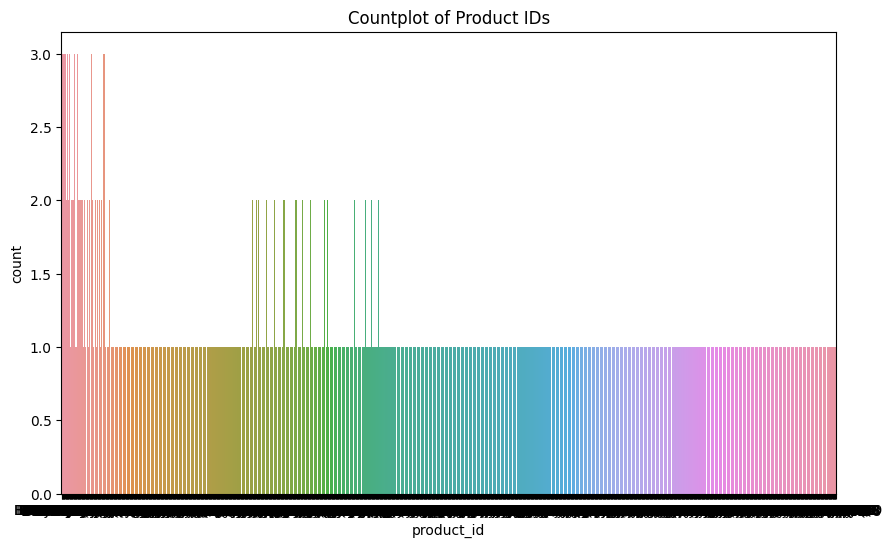

In [36]:
# Visualisasi dengan countplot untuk kolom kategoris
plt.figure(figsize=(10, 6))
sns.countplot(x='product_id', data=dataset)
plt.title('Countplot of Product IDs')
plt.show()

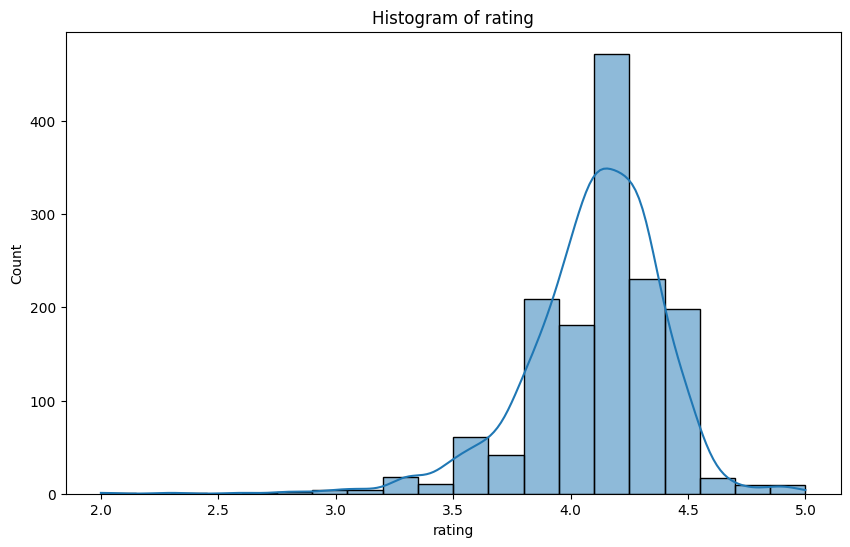

In [37]:
# Visualisasi dengan histogram untuk kolom numerik
plt.figure(figsize=(10, 6))
sns.histplot(dataset['rating'], bins=20, kde=True)
plt.title('Histogram of rating')
plt.show()

# MOdeling

In [110]:
new_data = dataset.copy()

In [119]:
new_data = new_data.drop('user_id', axis=1)

In [120]:
new_data.tail(7)

,rating,encoded_user_id,encoded_product_id
1465,4.9,13,1348
1466,4.9,13,1349
1467,4.9,13,1350
1468,4.9,13,1351
1469,4.9,13,1352
1470,4.9,13,1353
1471,4.9,13,1354


In [121]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1469 entries, 0 to 1471
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rating              1469 non-null   float64
 1   encoded_user_id     1469 non-null   int64  
 2   encoded_product_id  1469 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 45.9 KB


In [44]:
# Memisahkan fitur dan target
X_product = new_data[['encoded_product_id']]
X_rating = new_data[['rating']]
y = new_data['rating']

In [45]:
X_prod_train, X_prod_test, X_rating_train, X_rating_test, y_train, y_test = train_test_split(
    X_product, X_rating, y, test_size=0.2, random_state=42)

In [46]:
# Normalisasi fitur menggunakan StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_prod_train_scaled = scaler.fit_transform(X_prod_train)
X_prod_test_scaled = scaler.transform(X_prod_test)

In [47]:
# Membangun model regresi linier dengan TensorFlow
from tensorflow.keras import regularizers

model_rating = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,), name='input_product'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear', name='output_rating')
])

In [48]:
# Menentukan optimizer, fungsi loss, dan metrik evaluasi
model_rating.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_error', metrics=['mae'])

In [49]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model_rating.fit(X_prod_train_scaled, X_rating_train, validation_data=(X_prod_test_scaled, X_rating_test), epochs=10)

Epoch 1/10
37/37 [==============================] - 5s 16ms/step - loss: 3.7976 - mae: 3.7976 - val_loss: 3.4389 - val_mae: 3.4389
Epoch 2/10
37/37 [==============================] - 0s 9ms/step - loss: 3.0082 - mae: 3.0082 - val_loss: 2.5183 - val_mae: 2.5183
Epoch 3/10
37/37 [==============================] - 1s 14ms/step - loss: 1.8919 - mae: 1.8919 - val_loss: 1.2246 - val_mae: 1.2246
Epoch 4/10
37/37 [==============================] - 1s 15ms/step - loss: 0.8552 - mae: 0.8552 - val_loss: 0.6515 - val_mae: 0.6515
Epoch 5/10
37/37 [==============================] - 1s 14ms/step - loss: 0.5442 - mae: 0.5442 - val_loss: 0.4233 - val_mae: 0.4233
Epoch 6/10
37/37 [==============================] - 0s 13ms/step - loss: 0.3638 - mae: 0.3638 - val_loss: 0.2864 - val_mae: 0.2864
Epoch 7/10
37/37 [==============================] - 0s 8ms/step - loss: 0.2726 - mae: 0.2726 - val_loss: 0.2246 - val_mae: 0.2246
Epoch 8/10
37/37 [==============================] - 0s 13ms/step - loss: 0.2341 - mae

In [50]:
# Evaluasi performa model rating pada set pengujian
from sklearn.metrics import mean_absolute_error

rating_predictions = model_rating.predict(X_prod_test_scaled)
mae_rating = mean_absolute_error(X_rating_test, rating_predictions)
print(f'Mean Absolute Error (Rating): {mae_rating}')

10/10 [==============================] - 1s 10ms/step
Mean Absolute Error (Rating): 0.199238141702146


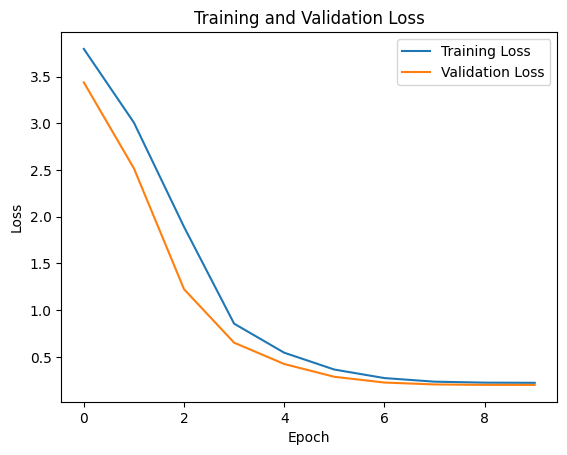

In [51]:
# Menampilkan plot loss dan validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [52]:
# Assuming X_test contains user-product pairs for which you want predictions
predictions = model_rating.predict(X_prod_test_scaled)

10/10 [==============================] - 0s 4ms/step


In [144]:
def recommend_products(encoded_user_id, dataset, top_k_rating=5):
    # Filter dataset berdasarkan user_id dan encoded_user_id
    user_data = dataset[(dataset['encoded_user_id'] == encoded_user_id)].drop_duplicates(subset='user_id')

    # Jika user tidak memiliki data, kembalikan pesan
    if user_data.empty:
        return f"User dengan ID {encoded_user_id} tidak ditemukan dalam dataset."

    # Ambil sampel acak dari dataset
    random_products = dataset.sample(n=top_k_rating).reset_index(drop=True)

    return user_data[['user_name']], random_products[['product_id', 'product_name', 'rating_x', 'product_link']]

In [145]:
# Contoh penggunaan
# Gantilah 'user_id', 'encoded_user_id', dan 'dataset' dengan data sesungguhnya
encoded_user_id_example = 4
dataset_example = pd.merge(df_new, dataset, on=['product_id', 'user_id'], how='inner')

In [146]:
recommendations_user, top_5_recommendations = recommend_products(encoded_user_id_example, dataset_example)

In [147]:
print(f"\nRekomendasi untuk {(recommendations_user).to_string(index=False)} ! :" +"\n"+ f"\n{top_5_recommendations}")


Rekomendasi untuk                                                                            user_name
rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK,Bhargav,Durai Vignesh,Amazon Customer ! :

   product_id                                       product_name  rating_x  \
0  B0B3MMYHYW  OnePlus 126 cm (50 inches) Y Series 4K Ultra H...       4.2   
1  B01F7B2JCI  Dynore Stainless Steel Set of 4 Measuring Cup ...       4.2   
2  B0941392C8  Lava Charging Adapter Elements D3 2A Fast Char...       3.7   
3  B09TT6BFDX  Cotbolt Silicone Protective Case Cover for LG ...       4.5   
4  B0949FPSFY  Bulfyss Stainless Steel Digital Kitchen Weighi...       4.1   

                                        product_link  
0  https://www.amazon.in/OnePlus-50-inches-Androi...  
1  https://www.amazon.in/Dynore-Stainless-Measuri...  
2  https://www.amazon.in/Lava-Elements-Charging-S...  
3  https://www.amazon.in/Cotbolt-Silicone-Protect...  
4  https://www.amazon.in/Bulfyss-Stainless-Weighi...  


In [57]:
# Menyimpan model ke dalam format H5
model_rating.save('/content/TrackMate_Model.h5')

In [148]:
files.download('/content/TrackMate_Model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>